# Phys 581 Winter 2019
# Assignment #3: Data fitting
## Alexander Hickey, 10169582

In [2]:
#Import useful libraries
import numpy as np
import scipy.stats
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

### Introduction

Type stuff...

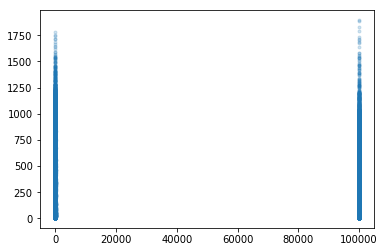

dtype([('year', '<i4'), ('day', '<i4'), ('hour', '<i4'), ('minute', '<i4'), ('imf_id', '<i4'), ('plasma_id', '<i4'), ('imf_n_average', '<i4'), ('plasma_n_average', '<i4'), ('percent_interpolated', '<i4'), ('timeshift', '<i4'), ('timeshift_rms', '<i4'), ('pfn_rms', '<f4'), ('observation_time_delta', '<i4'), ('b_magnitude', '<f4'), ('bx', '<f4'), ('by', '<f4'), ('bz', '<f4'), ('by_gsm', '<f4'), ('bz_gsm', '<f4'), ('b_magnitude_rms', '<f4'), ('b_vector_rms', '<f4'), ('v', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('proton_density', '<f4'), ('temperature', '<f4'), ('dynamic_pressure', '<f4'), ('electric_field', '<f4'), ('plasma_beta', '<f4'), ('alfven_mach_number', '<f4'), ('pos_x', '<f4'), ('pos_y', '<f4'), ('pos_z', '<f4'), ('bow_x', '<f4'), ('bow_y', '<f4'), ('bow_z', '<f4'), ('ae_index', '<i4'), ('al_index', '<i4'), ('au_index', '<i4'), ('symd_index', '<i4'), ('symh_index', '<i4'), ('asymd_index', '<i4'), ('asymh_index', '<i4'), ('pc_index', '<f4'), ('magnetosonic_mach_numbe

In [3]:
#Data doesn't make sense
data = np.load('omni_1min_2014.npy')
plt.plot( data['vz'], data['ae_index'], '.', alpha=0.2 )
plt.show()
data.dtype

Browsing through the documentation of the data, we see that the records corresponding to missed data are set to 9999. 

In [4]:
# Standardize variables to reduce numerical instability
dtype = np.dtype([ ('min', np.double), ('max', np.double), ('mean', np.double), ('stdev', np.double)])

process = {}
process['bz'] = np.array([(-29, +29, np.nan, np.nan)], dtype=dtype)
process['bx'],process['by'] = process['bz'].copy(), process['bz'].copy()
process['vx'] = np.array([(-2100, +50.0, np.nan, np.nan)], dtype=dtype) 
process['vy'],process['vz'] = process['vx'].copy(), process['vx'].copy()
process['ae_index'] = np.array([(-100, +2999, np.nan, np.nan)], dtype=dtype) 

In [5]:
alltrue = np.ones( len(data), dtype=np.bool )

for name in process:
    p = process[name]
    wgood = (data[name] >= p['min']) & (data[name] <= p['max'])
    alltrue = alltrue & wgood   
    
newdat = {}
for name in process:
    p = process[name]
    dat = data[name][alltrue].astype(np.double)

    if np.isnan( p['mean'] ):
        p['mean'] = np.mean( dat )
        p['stdev'] = np.std( dat )
        dat = ( dat - p['mean'] ) / p['stdev']
    
    newdat[name] = dat

In [6]:
# we want to fit 'ae_index' using one or more of the other quantities
#
if 'ae_index' in newdat:
    yfit = newdat.pop('ae_index')
    xfit = newdat.copy()

print( 'xfit: ', xfit, '\n yfit:', yfit)

xfit:  {'bz': array([-0.80466454, -0.86424481, -0.96638243, ...,  0.58554144,
        0.59689005,  0.56851853]), 'bx': array([-0.26830738, -0.28819136, -0.25978566, ...,  1.84223723,
        1.85075901,  1.80815041]), 'by': array([ 0.90557357,  0.83736941,  0.7856283 , ..., -0.22332312,
       -0.31739786, -0.46791743]), 'vx': array([ 0.0732012 ,  0.0732012 ,  0.07724639, ..., -1.87935849,
       -1.83216263, -1.90093423]), 'vy': array([-0.51327294, -0.51327294, -0.44575518, ...,  0.22942262,
        0.11367786, -0.95213852]), 'vz': array([-0.41901966, -0.41901966, -0.24957967, ..., -0.67317967,
       -0.46667464, -0.15426965])} 
 yfit: [-0.83895792 -0.81482337 -0.80275609 ... -0.74845335 -0.74845335
 -0.74241971]


Plotting the standardized data shows that the data is grouped togethor and of order 1.

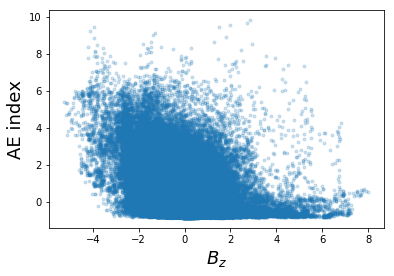

In [18]:
plt.plot( xfit['bz'], yfit,'.', alpha=.2)
plt.xlabel('$B_z$',fontsize=18)
plt.ylabel('AE index',fontsize=18)
plt.show()

##### Task:

Use tools in scipy.optimize (or elsewhere) to fit a linear model with a single variable 

 $$ AE = c_1 B_z $$

by finding the value of $c_1$ which minimizes the goodness of fit given by 

 $$ \chi^2 = \sum (\mathrm{model} - \mathrm{data})^2 $$

then try two variables

 $$ AE = c_1 B_z + c_2 v_x $$
 
then try a non-linear transformation of a single variable
 
 $$ AE = c_1 B_z + c_2 v_x^2 $$ 
 
then try cross terms 

 $$ AE = c_1 B_z + c_2 v_x + c_3 B_z v_x $$ 
 
then explore combinations and transformations of variables to obtain "the best" model.  Think about what that means.

In [31]:
def fitfunc(param, *args):
    """ optimizers call this function to determine best-fit parameters
       
       args contains
       y: array of values to be fit
       x: dict of arrays of values for model
    """
    
    # unpack arguments and calculate figure-of-merit
    y, x, model = args
    return chi2( y, newdat, model, param )

def chi2(y, x, model, param):
    """ difference between model and observations,
        divided by # of points to give number of order 1
    """
    dy = y - model(param, x)
    return np.sum(dy**2) / len(y)

def model_1(param, x):
    '''
    Linear, single coefficient
    '''
    y =  x['bz'] * param[0]
    
    return y

def model_2(param, x):
    '''
    Linear
    '''
    y = param[0] + x['bz'] * param[1]
    return y


def model_3(param, x):
    '''
    Linear, two variables
    '''
    y = param[0] + param[1]*x['bz'] + param[2] * x['vx']
    return y


def model_4(param, x):
    '''
    Quadratic vx
    '''
    y = param[0] + param[1]*x['bz'] + param[2] * x['vx']*x['vx']
    
    return y

def model_5(param, x):
    '''
    Cross terms
    '''
    y = param[0] + param[1]*x['bz']+ param[2]*x['vx'] + param[3]*x['bz']*x['vx']
    
    return y

print( chi2( yfit, xfit, model_bz, (0, -1) ) )
print( chi2( yfit, xfit, model_bz, (0, 0) ) )
print( chi2( yfit, xfit, model_bz, (0, +1) ) )

1.2374274051728684
1.0
2.762572594827131


Text(0.5, 0, 'p1')

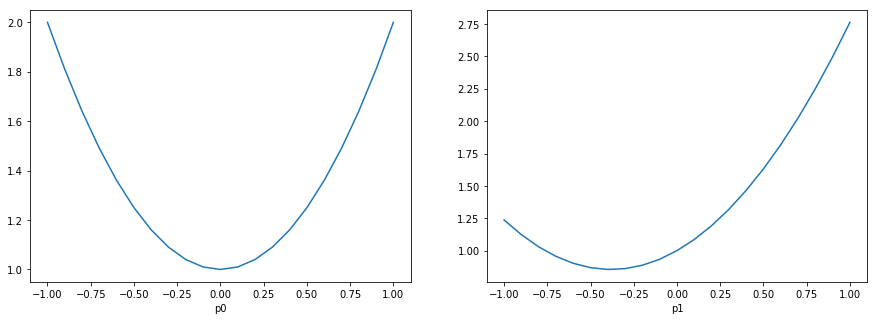

In [20]:
fig, axes = plt.subplots(1,2, figsize=(15,5) )

plt.sca( axes[0] )
p0 = np.linspace(-1, +1, 21)
q0 = [chi2( yfit, xfit, model_bz, (_,0) ) for _ in p0]
plt.plot(p0, q0)
plt.xlabel('p0')

plt.sca( axes[1] )
p1 = np.linspace(-1, +1, 21)
q1 = [chi2( yfit, xfit, model_bz, (0,_) ) for _ in p1]
plt.plot(p1, q1)
plt.xlabel('p1')

In [35]:
scipy.optimize.minimize(fitfunc, [0,1,1], (yfit, xfit, model_3) )

      fun: 0.8062733265085645
 hess_inv: array([[ 1.00000000e+00, -2.19533509e-07,  2.56038543e-07],
       [-2.19533509e-07,  5.00882912e-01,  2.04663800e-02],
       [ 2.56038543e-07,  2.04663800e-02,  5.00872867e-01]])
      jac: array([1.49011612e-08, 3.72529030e-08, 5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([-7.16150818e-09, -3.90259469e-01, -2.20063507e-01])

Next try a more complicated model.

In [37]:
def complicated_model():
    
    return 1

### Conclusion

In conclusion...